## RandomForest Regressor Pipeline - Data Cleaning, Feature Engineering, Training & Analysis

In [6]:
# 📦 Импорт библиотек
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# 🔧 Интерактивный режим
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from config import *

In [7]:
# 🔹 Настройки отображения
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 4)

In [ ]:
# 1️⃣ Загрузка и исследование данных
df_income = pd.read_csv(f'{DATA_PATH['parsed']}income_2023.csv')
df_weather = pd.read_csv(f'{DATA_PATH['parsed']}weather_2023.csv')
df_calendar = pd.read_csv(f'{DATA_PATH['parsed']}calendar_2023.csv')
# df_price = pd.read_csv(f'{DATA_PATH['parsed']}price_2023.csv')
df = df_income.merge(df_weather, on="day", how='left')
display(df.info()) # Структура
display(df.describe()) # Сводка
display(df.isna().sum()) # Просмотр NA

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361 entries, 0 to 360
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   day            361 non-null    int64  
 1   income         361 non-null    int64  
 2   cash           361 non-null    int64  
 3   temperature    361 non-null    float64
 4   wind_speed     361 non-null    float64
 5   precipitation  361 non-null    float64
dtypes: float64(3), int64(3)
memory usage: 17.1 KB


None

,day,income,cash,temperature,wind_speed,precipitation
count,361.000000,361.000000,361.000000,361.000000,361.000000,361.000000
mean,184.490305,154681.842105,15.216066,-3.754017,21.576454,7.436842
std,105.133014,62698.872656,7.100694,15.795985,8.574716,11.756644
min,1.000000,18384.000000,0.000000,-45.700000,5.000000,1.000000
25%,95.000000,119990.000000,10.000000,-14.200000,15.400000,1.000000
50%,185.000000,154552.000000,15.000000,-3.000000,20.500000,2.200000
75%,275.000000,186097.000000,20.000000,9.400000,26.100000,8.500000
max,365.000000,801831.000000,79.000000,25.900000,59.300000,100.000000


day              0
income           0
cash             0
temperature      0
wind_speed       0
precipitation    0
dtype: int64

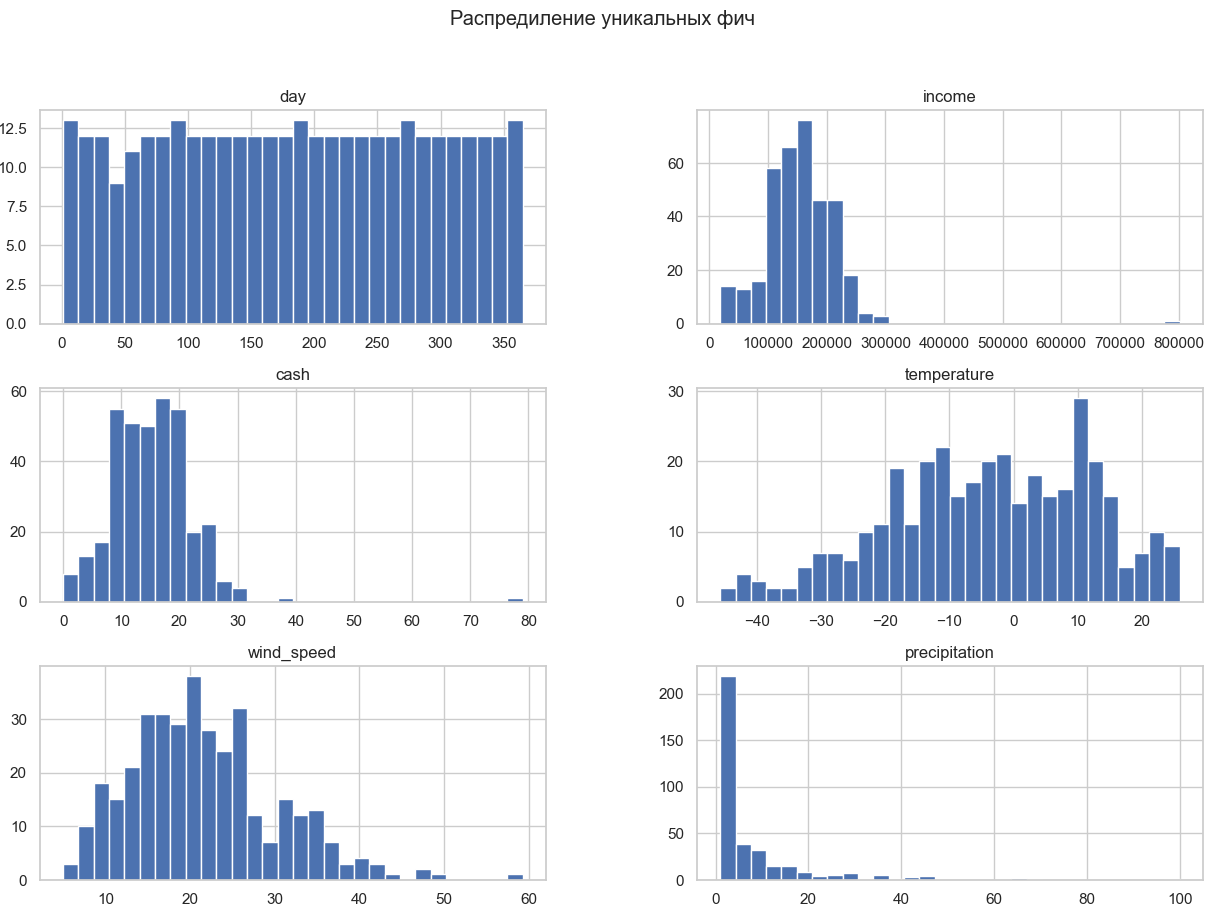

In [9]:
# 📊 Распределения параметров
df.hist(bins=30, figsize=(15, 10))
plt.suptitle("Распредиление уникальных фич")
plt.show()

In [10]:
# 2️⃣ Расширение классов параметров
# Пример: округление числовых параметров
# df['param_rounded'] = df['your_param'].round(1)
# Пример: бининг признаков
# df['param_binned'] = pd.cut(df['your_param'], bins=10)

In [11]:
# Вариант 0: округляем доход до 100, температуру, осадки и ветер до 1
df['income'] = df['income'].round(-2)
df['temperature'] = df['temperature'].round(0)
df['wind_speed'] = df['wind_speed'].round(0)
df['precipitation'] = df['precipitation'].round(0)

In [12]:
# Вариант 1: округляем доход до 100, температуру, осадки и ветер до 1. Билинг температуры, осадков и ветра по 15
df['income'] = df['income'].round(-2)
df['temperature'] = df['temperature'].round(0)
df['wind_speed'] = df['wind_speed'].round(0)
df['precipitation'] = df['precipitation'].round(0)
# 
for column in ['temperature', 'wind_speed', 'precipitation']:
    df[column] = pd.cut(df[column], bins=15).cat.codes

In [13]:
# 3️⃣ Обработка выбросов
Q1 = df['income'].quantile(0.25)
Q3 = df['income'].quantile(0.75)
low, high = [Q1 - 1.5 * (Q3 - Q1), Q3 + 1.5 * (Q3 - Q1)]
df = df[(df['income'] >= low) & (df['income'] <= high)]

count       357.000000
mean     152501.400560
std       51389.471479
min       23300.000000
25%      120000.000000
50%      154100.000000
75%      185700.000000
max      285000.000000
Name: income, dtype: float64

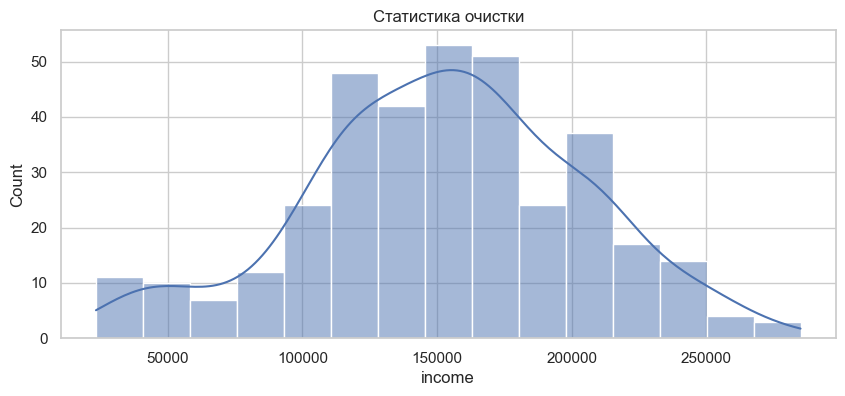

In [14]:
# 4️⃣ Статистика до и после обработки
display(df['income'].describe())
sns.histplot(df['income'], kde=True)
plt.title("Статистика очистки")
plt.show()

In [15]:
# 5️⃣ Разделение на тренировочные и тестовые данные
X = df[['day', 'temperature', 'precipitation']]
y = df['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# 6️⃣ Подбор гиперпараметров
params = {
    'n_estimators': [100, 1000],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 4, 8, 16]
}
grid = GridSearchCV(RandomForestRegressor(random_state=42), params, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
display("Best params:", grid.best_params_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


'Best params:'

{'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 1000}

In [17]:
# 7️⃣ Обучение финальной модели
model = grid.best_estimator_
y_pred = model.predict(X_test)

In [18]:
# 8️⃣ Оценка качества
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
display(f"MAE: {mae:.2f}, MSE: {mse:.2f}, R2: {r2:.2f}")

'MAE: 26213.07, MSE: 1128111068.90, R2: 0.43'

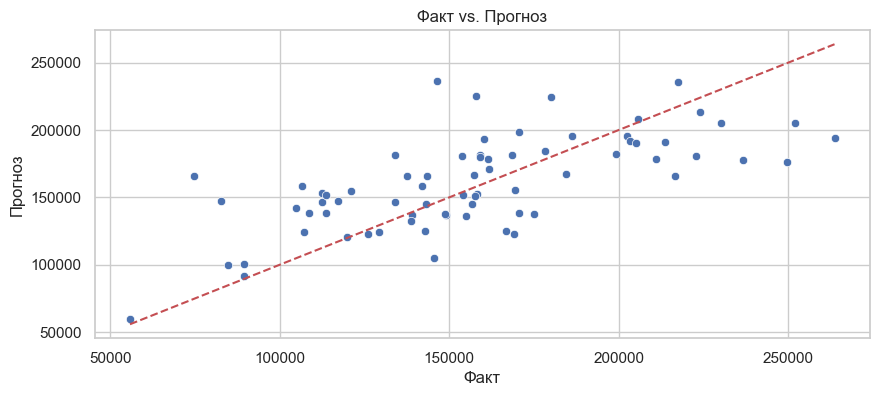

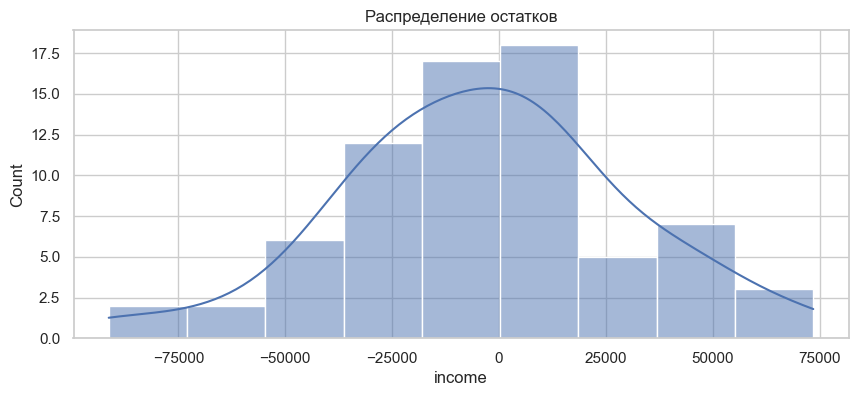

In [20]:
# 🔍 Графики ошибок и отклонений
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Факт")
plt.ylabel("Прогноз")
plt.title("Факт vs. Прогноз")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r')
plt.show()

residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.title("Распределение остатков")
plt.show()

In [ ]:
# 🔎 Анализ крайних точек ошибки
errors = abs(residuals)
worst = errors.sort_values(ascending=False).head(5)
display("Worst predictions:")
display(df.loc[worst.index])